In [1]:
import torch
from torch.distributions import Normal, Independent
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Simple generative model
d = 1
sigma_0 = 4
prior = Normal(torch.zeros(d), np.sqrt(sigma_0)*torch.ones(d))
likelihood = lambda x,theta: Normal(theta, torch.ones_like(theta)).log_prob(x)
x = torch.tensor([1]*d)
sigma_post = 1/(1/sigma_0 + 1)
mu_post = sigma_post*x
p = Normal(mu_post, np.sqrt(sigma_post)*torch.ones(1))

In [3]:
means = torch.linspace(-15,15, 1000)
m_1 = []
q05_1 = []
q95_1 = []
SNR_m_1 = []
SNR_ql_1 = []
SNR_qu_1 = []
true_grads = []
for i in means:
    d = 1
    mean = torch.tensor([i]*d, requires_grad=True)
    q = torch.distributions.Normal(mean,np.sqrt(sigma_post)*torch.ones(d))
    true_grad = torch.autograd.grad(torch.distributions.kl.kl_divergence(p, q), mean)
    true_grads.append(true_grad)
    mean = mean.detach()
    q = torch.distributions.Normal(mean, sigma_post*torch.ones(d))
    N=10
    theta = q.sample((5000,N))
    grads = 5/4*(theta-mean)
    logp = likelihood(x,theta) + prior.log_prob(theta)
    weights = torch.softmax(logp-q.log_prob(theta),1)
    estimator = -(weights*grads).sum(1)
    t = torch.ones(5000).reshape(-1,d)*i
    m_1.append(estimator.mean())
    q05_1.append(estimator.quantile(0.2))
    q95_1.append(estimator.quantile(0.8))
    
    estimator_m = estimator.reshape(100, -1).mean(-1).abs()
    estimator_s = estimator.reshape(100, -1).std(-1)
    SNRs = estimator_m/estimator_s
    SNR_m_1.append(SNRs.mean())
    SNR_ql_1.append(SNRs.quantile(0.2))
    SNR_qu_1.append(SNRs.quantile(0.8))

In [4]:
means = torch.linspace(-15,15, 1000)
m_2 = []
q05_2 = []
q95_2 = []
SNR_2 = []

SNR_m_2 = []
SNR_ql_2 = []
SNR_qu_2 = []
for i in means:
    d = 1
    mean = torch.tensor([i]*d)
    q = torch.distributions.Normal(mean, np.sqrt(sigma_post)*torch.ones(d))
    N=100
    theta = q.sample((5000,N))
    logp = likelihood(x,theta) + prior.log_prob(theta)
    grads =5/4*(theta-mean)
    weights = torch.softmax(logp-q.log_prob(theta),1)
    estimator = -(weights*grads).sum(1)
    t = torch.ones(5000).reshape(-1,d)*i
    m_2.append(estimator.mean())
    q05_2.append(estimator.quantile(0.2))
    q95_2.append(estimator.quantile(0.8))
    SNR_2.append(estimator.mean().abs()/estimator.std())
    
    estimator_m = estimator.reshape(100, -1).mean(-1).abs()
    estimator_s = estimator.reshape(100, -1).std(-1)
    SNRs = estimator_m/estimator_s
    SNR_m_2.append(SNRs.mean())
    SNR_ql_2.append(SNRs.quantile(0.2))
    SNR_qu_2.append(SNRs.quantile(0.8))

In [5]:
means = torch.linspace(-15,15, 1000)
m_3 = []
q05_3 = []
q95_3 = []
SNR_3 = []

SNR_m_3 = []
SNR_ql_3 = []
SNR_qu_3 = []

for i in means:
    d = 1
    mean = torch.tensor([i]*d)
    q = torch.distributions.Normal(mean, np.sqrt(sigma_post)*torch.ones(d))
    N=1000
    theta = q.sample((5000,N))
    logp = likelihood(x,theta) + prior.log_prob(theta)
    grads = 5/4*(theta-mean)
    weights = torch.softmax(logp-q.log_prob(theta),1)
    estimator = -(weights*grads).sum(1)
    t = torch.ones(5000).reshape(-1,d)*i
    m_3.append(estimator.mean())
    q05_3.append(estimator.quantile(0.2))
    q95_3.append(estimator.quantile(0.8))
    SNR_3.append(estimator.mean().abs()/estimator.std())
    
    estimator_m = estimator.reshape(100, -1).mean(-1).abs()
    estimator_s = estimator.reshape(100, -1).std(-1)
    SNRs = estimator_m/estimator_s
    SNR_m_3.append(SNRs.mean())
    SNR_ql_3.append(SNRs.quantile(0.2))
    SNR_qu_3.append(SNRs.quantile(0.8))
    

In [6]:
all_estimates = []
for i in range(200):
    estimates = []
    for i in means:   
        mean = torch.tensor([i], requires_grad=True)
        q = torch.distributions.Normal(mean, np.sqrt(sigma_post)*torch.ones(1))
        s_q = q.rsample((1000,))
        weights = torch.exp(p.log_prob(s_q) - q.log_prob(s_q))
        logq = q.log_prob(s_q)
        logp = p.log_prob(s_q)
        loss = (weights*(logp-logq)).mean()
        grad = torch.autograd.grad(loss, mean, retain_graph=True)[0]
        estimates.append(grad)
    all_estimates.append(estimates)

In [7]:
all_estimates = torch.tensor([[float(j[0]) for j in i] for i in all_estimates])
fVB_m = all_estimates.mean(0)

In [8]:
estimator_m = torch.abs(all_estimates.reshape(20,10, -1).mean(1))
estimator_s = all_estimates.reshape(20, 10,-1).std(1)

In [9]:
SNRs = estimator_m/estimator_s

In [10]:
SNR_ql = SNRs.quantile(0.2, 0)
SNR_qu = SNRs.quantile(0.8, 0)
SNR_m = SNRs.mean(0)

In [141]:
from scipy.signal import savgol_filter
import numpy as np
def filters(x):
    return savgol_filter(np.array(torch.tensor(x).clamp(-10,10)), 71,2)

/home/manu/miniconda3/envs/test/lib/python3.8/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/manu/miniconda3/envs/test/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_2989/3874308632.py:23: MatplotlibDeprec

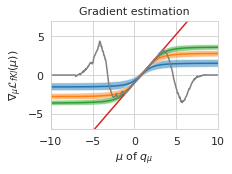

In [142]:
fig = plt.figure(figsize=(3,2))

sns.set_style("whitegrid")
plt.plot(means, filters(m_1))
plt.plot(means, filters(m_2))
plt.plot(means, filters(m_3))
plt.plot(means, true_grads)
plt.plot(means, filters(list(fVB_m)), color="grey")

plt.fill_between(means,filters(q05_1),filters(q95_1), alpha=0.5)
plt.fill_between(means,filters(q05_2),filters(q95_2), alpha=0.5)
plt.fill_between(means,filters(q05_3), filters(q95_3), alpha=0.5)
#plt.fill_between(means, filters(fVB_ql), filters(fVB_qu), alpha=0.5, color="grey")

plt.xlabel(r"$\mu$ of $q_\mu$", fontsize=11)
plt.ylabel(r"$\nabla_\mu \mathcal{L}_{fKl}(\mu))$", fontsize=11)
plt.title("Gradient estimation", fontsize=11)
plt.yticks(fontsize=11)
plt.xticks(fontsize=11)
plt.ylim(-7,7)
plt.xlim(-10,10)

plt.savefig("graident_estimation.svg", transparnet=True)

In [143]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

COLORS =["C0", "C1","C2","red", "Grey"]
labels = ["N = 10", "N = 100", "N = 1000","True Gradient", "fVB"]
handles = [mlines.Line2D([1],[1],color=COLORS[i], linewidth=2, label=labels[i]) for i in range(len(labels))]

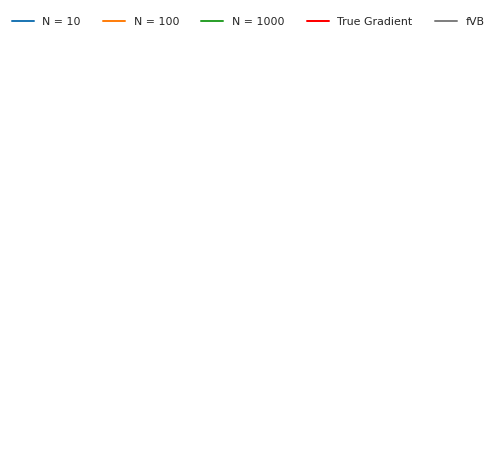

In [145]:
import seaborn as sns
with sns.axes_style("white"):
    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.legend(handles=handles, ncol=5, fontsize=11, frameon=False)
    fig.savefig("fig_legend.svg", transparent=True)

In [146]:
def filters(x):
    return savgol_filter(np.array(x), 5,2)

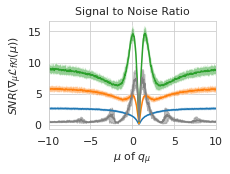

In [147]:
fig = plt.figure(figsize=(3,2))

plt.plot(means, filters(SNR_m_1))
plt.fill_between(means, filters(SNR_ql_1), filters(SNR_qu_1), alpha=0.5)

plt.plot(means, filters(SNR_m_2))
plt.fill_between(means, filters(SNR_ql_2), filters(SNR_qu_2), alpha=0.5)

plt.plot(means, filters(SNR_m_3))
plt.fill_between(means, filters(SNR_ql_3), filters(SNR_qu_3), alpha=0.5)

plt.plot(means, filters(SNR_m), color="grey")
plt.fill_between(means, filters(SNR_ql), filters(SNR_qu), alpha=0.5, color="grey")

plt.xlabel(r"$\mu$ of $q_\mu$", fontsize=11)
plt.ylabel(r"$SNR(\nabla_\mu \mathcal{L}_{fKl}(\mu))$", fontsize=11)
plt.title("Signal to Noise Ratio", fontsize=11)
plt.yticks(fontsize=11)
plt.xticks(fontsize=11)
plt.xlim(-10,10)

plt.savefig("snr.svg", transparent=True)

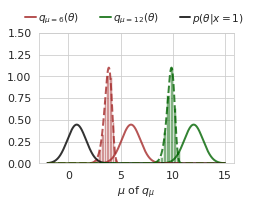

In [160]:
fig = plt.figure(figsize=(3.5,2.4))

mean = torch.tensor([6.], requires_grad=True)
q = torch.distributions.Normal(mean, np.sqrt(sigma_post)*torch.ones(1))
q2 = torch.distributions.Normal(mean+6, np.sqrt(sigma_post)*torch.ones(1))
x = torch.linspace(-2,15, 10000)
maxima = []
for i in range(10000):
    s_q = q.sample((10,))
    weights = torch.softmax(p.log_prob(s_q) - q.log_prob(s_q), 0)
    maxima.append(s_q[weights.argmax()].detach().numpy())
plt.plot(x, q.log_prob(x).exp().detach(), alpha=0.8, color="brown", linewidth=2)
plt.plot(x, q2.log_prob(x).exp().detach(), alpha=0.8, color="darkgreen", linewidth=2)
plt.plot(x, p.log_prob(x).exp(), color="black", alpha=0.8, linewidth=2)
#plt.hist(np.array(maxima), density=True, alpha=0.5, color="C0")
#plt.plot(x, (10*(1-q.cdf(x))**10*q.log_prob(x).exp()).detach(), color="C0", alpha=0.8)
maxima = []
for i in range(1000):
    s_q = q.sample((100,))
    weights = torch.softmax(p.log_prob(s_q) - q.log_prob(s_q), 0)
    maxima.append(s_q[weights.argmax()].detach().numpy())
plt.plot(x, (100*(1-q.cdf(x))**100*q.log_prob(x).exp()).detach(), color="brown", linestyle="--", alpha=0.8, linewidth=2)
plt.hist(np.array(maxima), density=True, alpha=0.5, color="brown")

maxima = []
for i in range(1000):
    s_q = q2.sample((100,))
    weights = torch.softmax(p.log_prob(s_q) - q2.log_prob(s_q), 0)
    maxima.append(s_q[weights.argmax()].detach().numpy())
plt.plot(x, (100*(1-q2.cdf(x))**100*q2.log_prob(x).exp()).detach(), color="darkgreen", linestyle="--", alpha=0.8, linewidth=2)
plt.hist(np.array(maxima), density=True, alpha=0.5, color="darkgreen")
plt.ylim(0,1.5)
plt.legend([r"$q_{\mu=6}( \theta )$", r"$q_{\mu=12}( \theta )$", r"$p(\theta|x=1)$"],handletextpad=0.2, fontsize=10.5, ncol=3,
           bbox_to_anchor=(0.1,0.24,1,1),frameon=False, handlelength=1)
plt.xlabel(r"$\mu$ of $q_\mu$", fontsize=11)
plt.yticks(fontsize=11)
plt.xticks(fontsize=11)

plt.savefig("implicit_density.svg")

In [77]:
import svgutils.transform as sg
import sys 

#create new SVG figure
fig = sg.SVGFigure("16cm", "12cm")

# load matpotlib-generated figures
fig1 = sg.fromfile('graident_estimation.svg')
fig2 = sg.fromfile('snr.svg')
fig3 = sg.fromfile('implicit_density.svg')
fig4 = sg.fromfile('fig_legend.svg')
# get the plot objects
plot1 = fig1.getroot()
plot1.moveto(30,10)
plot2 = fig2.getroot()
plot2.moveto(280,10)
plot3 = fig3.getroot()
plot3.moveto(530,-15)
plot4 = fig4.getroot()
plot4.moveto(-10,100)




# add text labels
txt1 = sg.TextElement(10,20, "A", size=18, weight="bold")
txt3 = sg.TextElement(520,20, "B", size=18, weight="bold")


# append plots and labels to figure
fig.append([plot1, plot2, plot3, plot4])
fig.append([txt1, txt3])

# save generated SVG files
fig.save("APPENDIX_gradient_estimation.svg")

In [ ]:
from IPython.display import SVG
SVG("APPENDIX_gradient_estimation.svg")

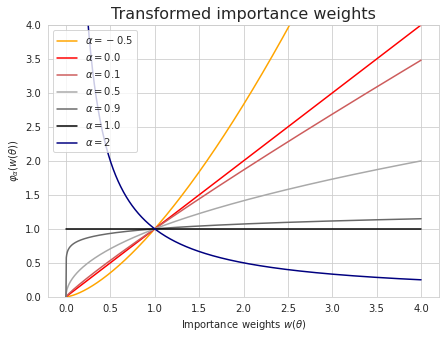

In [3]:
fig = plt.figure(figsize=(7,5))
sns.set_style("whitegrid")
y = torch.linspace(0,4,1000)
a_s = [-0.5, 0.,  0.1,0.5, 0.9,1., 2]
colors = ["orange", "red",  "indianred","darkgrey", "dimgrey", "black", "navy"]
for i,a in enumerate(a_s):
    plt.plot(y,y**(1-a), c=colors[i])
plt.ylim(0,4)
plt.legend([rf"$\alpha = {a}$" for a in a_s])
plt.xlabel(r"Importance weights $w(\theta)$")
plt.ylabel(r"$\varphi_\alpha(w(\theta))$")
plt.title("Transformed importance weights", fontsize=16)
plt.savefig("transformations.svg")

In [4]:
def compute_importance_weight_SNR(alpha=0, K=1000):
    s_q = q.rsample((200,K))
    logq = q.log_prob(s_q)
    logp = likelihood(x,s_q) + prior.log_prob(s_q)

    with torch.no_grad():
        weights = torch.exp(logp - logq)**(1-alpha)
        weights = weights/weights.sum(1).unsqueeze(1)
    loss = (weights*(logp-logq)).mean(-1).mean(-1)
    grad = torch.zeros(100)
    for i in range(100):
        grad[i] = torch.autograd.grad(loss[i], mean, retain_graph=True)[0]
    grad = grad[~torch.isnan(grad)]
    return torch.abs(grad.mean()/grad.std())

In [7]:
ms = [1., 2., 3.]
Ks = [1000]
SNRs = dict()
alphas = torch.linspace(-2,4,150)
for K in Ks:
    for m in ms:
        print(m)
        SNRS1 = []
        mean = torch.tensor([m], requires_grad=True)
        q = torch.distributions.Normal(mean, np.sqrt(sigma_post)*torch.ones(1))
        for alpha in alphas:
            SNRS1.append(compute_importance_weight_SNR(alpha, K = K))
        SNRs[(K,m)] = SNRS1

1.0
2.0
3.0


In [8]:
from matplotlib import cm
cmap = cm.get_cmap("viridis")

/home/macke/mgloeckler90/.conda/envs/sbi/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/macke/mgloeckler90/.conda/envs/sbi/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/macke/mgloeckler90/.conda/envs/sbi/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) 

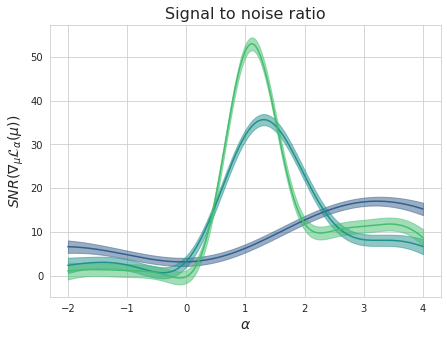

In [9]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
sns.set_style("whitegrid")
fig = plt.figure(figsize=(7,5))

kernel = RBF(2, (0.1, 5))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha=5)


X = alphas.numpy().reshape(-1,1)
y = np.array(SNRs[(1000, 1.)]).reshape(-1,1) 
# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

x = np.atleast_2d(np.linspace(-2, 4, 1000)).T
y_pred, sigma = gp.predict(x, return_std=True)
y_pred = y_pred.flatten()
plt.plot(x,y_pred, color=cmap(0.3) )
plt.fill_between(x.flatten(), y_pred-3*sigma, y_pred+3*sigma, alpha=0.5, color=cmap(0.3) )

X = alphas.numpy().reshape(-1,1)
y = np.array(SNRs[(1000, 2.)]).reshape(-1,1) 
# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

x = np.atleast_2d(np.linspace(-2, 4, 1000)).T
y_pred, sigma = gp.predict(x, return_std=True)
y_pred = y_pred.flatten()
plt.plot(x,y_pred, color=cmap(0.5) )
plt.fill_between(x.flatten(), y_pred-3*sigma, y_pred+3*sigma, alpha=0.5, color=cmap(0.5) )

X = alphas.numpy().reshape(-1,1)
y = np.array(SNRs[(1000, 3.)]).reshape(-1,1) 
# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

x = np.atleast_2d(np.linspace(-2, 4, 1000)).T
y_pred, sigma = gp.predict(x, return_std=True)
y_pred = y_pred.flatten()
plt.plot(x,y_pred, color=cmap(0.7) )
plt.fill_between(x.flatten(), y_pred-3*sigma, y_pred+3*sigma, alpha=0.5, color=cmap(0.7) )

plt.xlabel(r"$\alpha$", fontsize=14)
plt.ylabel(r"$SNR(\nabla_\mu \mathcal{L}_\alpha(\mu))$", fontsize=14)
plt.title("Signal to noise ratio", fontsize=16)

plt.savefig("snr_alpha.svg")

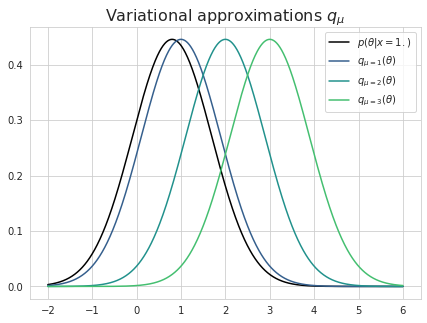

In [10]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(7,5))

x = torch.linspace(-2, 6, 1000)
q2 = torch.distributions.Normal(torch.ones(1)*1, np.sqrt(sigma_post)*torch.ones(1))
q3 = torch.distributions.Normal(torch.ones(1)*2, np.sqrt(sigma_post)*torch.ones(1))
q4 = torch.distributions.Normal(torch.ones(1)*3, np.sqrt(sigma_post)*torch.ones(1))

plt.plot(x, p.log_prob(x).exp(), color="black")
plt.plot(x, q2.log_prob(x).exp(), color=cmap(0.3))
plt.plot(x, q3.log_prob(x).exp(), color=cmap(0.5))
plt.plot(x, q4.log_prob(x).exp(), color=cmap(0.7))
plt.title("Variational approximations $q_\mu$", fontsize=16)
plt.legend([r"$p(\theta|x=1.)$", r"$q_{\mu = 1}(\theta)$", r"$q_{\mu = 2}(\theta)$", r"$q_{\mu = 3}(\theta)$"])
plt.savefig("distributions.svg")

In [163]:
import svgutils.transform as sg
import sys 

#create new SVG figure
fig = sg.SVGFigure("16cm", "12cm")

# load matpotlib-generated figures
fig1 = sg.fromfile('distributions.svg')
fig2 = sg.fromfile('snr_alpha.svg')
fig3 = sg.fromfile('transformations.svg')
# get the plot objects
plot1 = fig1.getroot()
plot1.moveto(10,10, scale_x=0.3, scale_y=0.3)
plot2 = fig2.getroot()
plot2.moveto(160,10, scale_x=0.3, scale_y=0.3)
plot3 = fig3.getroot()
plot3.moveto(320,10, scale_x=0.3, scale_y=0.3)




# add text labels
txt1 = sg.TextElement(10,20, "A", size=11, weight="bold")
txt3 = sg.TextElement(320,20, "B", size=11, weight="bold")


# append plots and labels to figure
fig.append([plot1, plot2, plot3])
fig.append([txt1, txt3])

# save generated SVG files
fig.save("APPENDIX_alpha_div.svg")

FileNotFoundError: [Errno 2] No such file or directory: 'distributions.svg'

In [12]:
from IPython.display import SVG
SVG("APPENDIX_alpha_div.svg")

In [6]:
import sbibm
from sbivibm.plotting import pairplot_sns, plot_metrics, get_full_dataset, runtime_plot, plot_runtimes, plot_samples
from sbivibm.utils import query, get_tasks, delete_by_id, get_samples_by_id, get_posterior_by_id
from sbivibm.tasks import Pyloric
import pandas as pd

In [7]:
df_snlpe = get_full_dataset("benchmark_snlpe").query("num_rounds==10")
df = get_full_dataset("main_benchmark").query("task=='two_moons'").query("loss=='elbo'").query("num_rounds==10").query("algorithm == 'SNLVI'")
df = df[df["parameters"].str.contains("'naive'")]

samples_snlpe = get_samples_by_id("benchmark_snlpe", "156ebe79-ec7b-4c18-85d6-9d95c30943d0")
samples = get_samples_by_id("main_benchmark", "f1e3dc24-8422-4ff8-b462-e639983bb1d0")

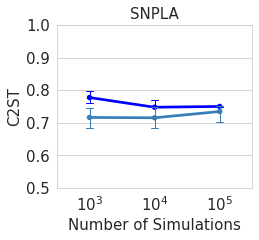

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
fontsize=15
with sns.axes_style("whitegrid", rc={"font.size":11,"axes.titlesize":18,"axes.labelsize":11}):
    fig, axes = plt.subplots(1, figsize=(3.5,3))
    sns.pointplot(data=df_snlpe,x="num_simulations", y="c2st", color="blue", ax = axes, capsize=.1, errwidth=1., markers=".", linewidth=0.5, ci=95)
    sns.pointplot(data=df,x="num_simulations", y="c2st", color="#377eb8", ax = axes,capsize=.1, errwidth=1., markers=".", linewidth=0.5, ci=95)
    
    axes.set_ylim(0.5,1)
    axes.set_ylabel("C2ST", fontsize=fontsize)
    axes.set_xlabel("Number of Simulations", fontsize=fontsize)
    axes.set_xticklabels([rf"$10^{int(np.log10(i))}$" for i in [1000,10000,100000]], fontsize=fontsize)
    axes.set_yticklabels([0.5,0.6,0.7,0.8,0.9,1.0], fontsize=fontsize)
#     axes[1].set_ylabel("MMD", fontsize=12)
#     axes[1].set_xlabel("Number of Simulations", fontsize=12)
#     axes[1].set_xticklabels([rf"$10^{int(np.log10(i))}$" for i in [1000,10000,100000]], fontsize=11)
    axes.set_title("SNPLA", fontsize=fontsize)
    #axes[1].set_title("SNPLA", fontsize=16)
    line1 = mlines.Line2D([0,1],[0,1], color="blue", label=" Original \n SNPLA")
    line2 = mlines.Line2D([0,1],[0,1], color="#377eb8", label=" Our SNPLA \n (SNVI+rKL)")
    #axes.legend(handles=[line1,line2], ncol=2, frameon=False, bbox_to_anchor=(-0.1,-0.7,1,1), fontsize=fontsize)
    #fig.suptitle("Two moons \n", fontsize=20, y=0.9, x=0.44)

    fig.savefig("APPENDIX_snple_comparission.svg")

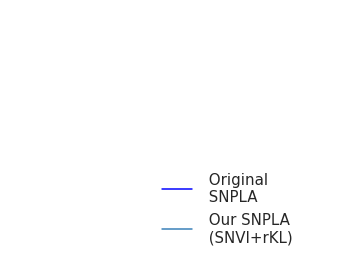

In [59]:
fig = plt.figure()
sns.set()
line1 = mlines.Line2D([0,1],[0,1], color="blue", label=" Original \n SNPLA")
line2 = mlines.Line2D([0,1],[0,1], color="#377eb8", label=" Our SNPLA \n (SNVI+rKL)")
plt.axis("off")
plt.legend(handles=[line1,line2], ncol=1, frameon=False, bbox_to_anchor=(-0.1,-0.7,1,1), fontsize=fontsize)
fig.savefig("legend.svg", transparent=True)